In [1]:
from classifier_free_guidance_greg import GaussianDiffusion, Unet
from accelerate import Accelerator
import torch 

import sys
sys.path.insert(1,'../data_utils_v2')
from Sample import Sample

2023-12-22 15:47:43.285962: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
fp = './results_small/model-120.pt'#'./results/model-120.pt'
embedding_dimensions = (1,260,256)

num_beads = 65
two_channels = False

In [3]:
c,image_size = 1+int(two_channels), num_beads-1
model = Unet(
    dim=64,
    #num_classes,
    cond_drop_prob = 0.5,
    init_dim = None,
    out_dim = None,
    dim_mults=(1, 2, 4, 8),
    channels = c,
    resnet_block_groups = 8,
    learned_variance = False,
    learned_sinusoidal_cond = False,
    random_fourier_features = False,
    learned_sinusoidal_dim = 16,
    attn_dim_head = 32,
    attn_heads = 4,
    embedding_dimensions=embedding_dimensions
)

diffusion = GaussianDiffusion(
    model,
    image_size=image_size,
    timesteps = 1000,
    sampling_timesteps = None,
    objective = 'pred_noise',
    beta_schedule = 'cosine',
    ddim_sampling_eta = 1.,
    offset_noise_strength = 0.,
    min_snr_loss_weight = False,
    min_snr_gamma = 5
)

try: 
    diffusion.to('cuda')
except:
    pass

In [4]:
diffusion.load(fp)

In [5]:
import pandas as pd
#embeddings = pd.read_pickle('../../data/embeddings/chrom_X.tar.gz')
embeddings = pd.read_pickle('../../data/embeddings/chrom_1.tar.gz')

In [16]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

def get_HiC(diffusion,embedding,n_maps=1000,cond_scale = 6., rescaled_phi = 0.7,plot=True):

    if embedding.shape not in [torch.Size([1,1,260,256]),torch.Size([1,260,256])]:
        raise Exception(f"Expected embedding shape (1,260,256) or (1,1,260,256), but received {embedding.shape}")

    diffusion.eval()
    sample = Sample(
        data = diffusion.sample(embedding.to(diffusion.device).expand(n_maps,-1,-1,-1),cond_scale=cond_scale,rescaled_phi=rescaled_phi)
    )

    hic_map = sample.get_scHiC().mean(0)[0,...]

    if plot: 
        fig = plt.figure()
        ax = fig.add_subplot(111)
        im = ax.matshow(hic_map.cpu().numpy(),norm=LogNorm(vmin=hic_map[hic_map>0].min(),vmax=1),cmap='RdYlBu_r')
        cbar = fig.colorbar(im)
    
    return sample, hic_map 
    
    

In [27]:
import cooltools.lib.plotting # provides 'fall' colormap
norm = LogNorm(vmax=1) 
def plot_hic(hic_map,norm=norm):
    
    fig = plt.figure()
    ax = fig.add_subplot(111) 
    
    im = ax.matshow(
        hic_map.cpu().numpy(),
        norm=norm,
        cmap='fall',
        #extent=(region[1], region[2], region[2], region[1])
    );
    ax.xaxis.set_visible(False)
    
    cbar = fig.colorbar(im, label='Interaction Frequencies',location='right');

    return fig,ax,im,cbar

In [17]:
region = 0 
embeddings.iloc[region,0]

tensor([[[ 0.0608,  3.5931, -1.4655,  ...,  0.8881, -0.2752, -2.6679],
         [-1.0577,  3.9899,  0.2972,  ...,  2.0217,  0.1286, -0.7900],
         [-1.1141,  2.9361, -2.5720,  ...,  1.2188, -2.4308,  2.5277],
         ...,
         [-0.6375,  1.2439,  0.3090,  ..., -1.1241,  1.1532,  2.7986],
         [ 1.8492,  1.3955, -2.4614,  ..., -1.2247, -0.7906,  1.1656],
         [-1.3701,  0.8691,  1.1013,  ...,  0.1064,  2.1044,  1.5171]]])

In [21]:
n_maps=100
emb = embeddings.iloc[region,0].to(diffusion.device).expand(n_maps,-1,-1,-1)

cond_scale=1
rescaled_phi=.7

sample = Sample(
    data = diffusion.sample(emb,cond_scale=cond_scale,rescaled_phi=rescaled_phi)
)

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

NameError: name 'n' is not defined

In [25]:
sample = Sample(data=sample.batch) 

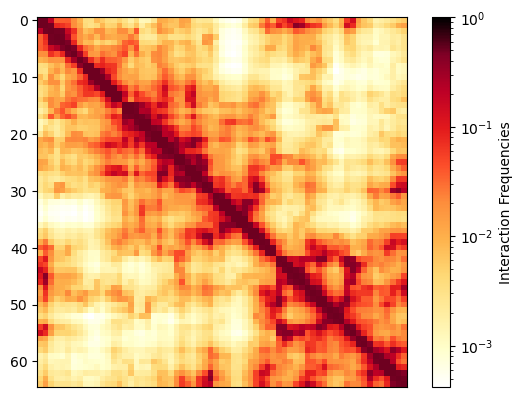

In [31]:
r_c=1.5
sigma=2
sim_mat = sample.contact_probabilities(r_c=1.5,sigma=0)#r_c=best_r_c.to(best_sample.device),sigma=best_sigma.to(best_sample.device))
plot_hic(sim_mat);

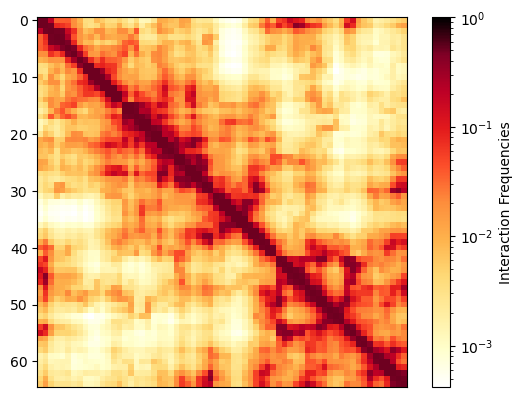

In [32]:
r_c=1.5
sigma=1
sim_mat = sample.contact_probabilities(r_c=1.5,sigma=0)#r_c=best_r_c.to(best_sample.device),sigma=best_sigma.to(best_sample.device))
plot_hic(sim_mat);

In [6]:
embeddings.index[0]

(1300000, '1', 780000)

In [11]:
n=0
for region in range(0,1000,50): 
    for cond_scale in [float(k) for k in range(1,11)]:
        for rescaled_phi in [k/10 for k in range(1,11)]: 
            n+=1
n

2000

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

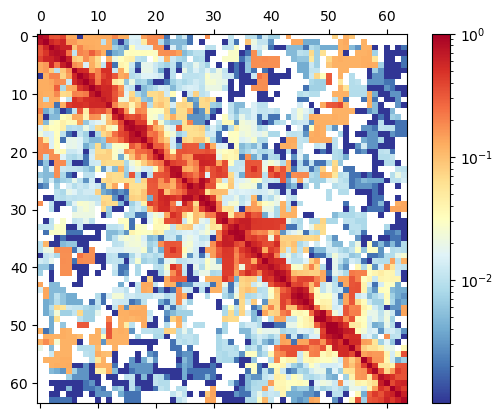

In [15]:
n = 0
n_maps = 1000
cond_scale = 1.
rescaled_phi = 0.5
emb = embeddings.iloc[n].values[0]
sample,hic_map = get_HiC(diffusion,emb,n_maps,cond_scale,rescaled_phi)

In [29]:
milestone=69
chrom=22
sample.to('cpu') 
pd.to_pickle(sample,f'./sampling_small/sample_{0}_{int(cond_scale)}_{int(10*rescaled_phi)}_{milestone}_{chrom}.pkl')

In [26]:
embeddings.iloc[n]

Data    [[[tensor(0.6091), tensor(0.4705), tensor(0.28...
Name: (1300000, 22, 16980000), dtype: object

In [13]:
len(embeddings)

1627

In [14]:
embeddings.iloc[n].name

(1300000, '22', 16980000)

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

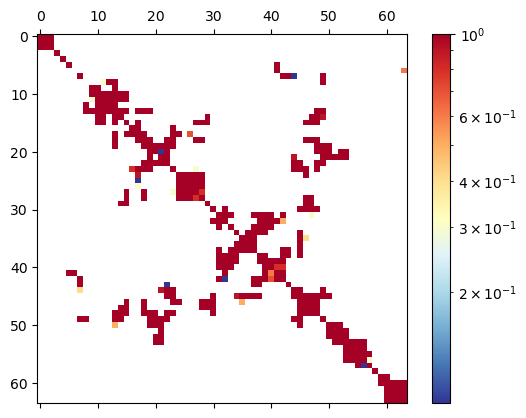

In [25]:
n = 1000
n_maps = 10
cond_scale = 6.
rescaled_phi = 0.7
emb = embeddings.iloc[n].values[0]
sample,hic_map = get_HiC(diffusion,emb,n_maps,cond_scale,rescaled_phi)

In [29]:
embeddings.iloc[n].name

(1300000, 'X', 20220000)

# large model

In [9]:
fp = './results_large/model-81.pt'

In [10]:
c,image_size = 1+int(two_channels), num_beads-1
model = Unet(
    dim=128,
    #num_classes,
    cond_drop_prob = 0.5,
    init_dim = None,
    out_dim = None,
    dim_mults=(1, 2, 4, 8),
    channels = c,
    resnet_block_groups = 8,
    learned_variance = False,
    learned_sinusoidal_cond = False,
    random_fourier_features = False,
    learned_sinusoidal_dim = 16,
    attn_dim_head = 32,
    attn_heads = 4,
    embedding_dimensions=embedding_dimensions
)

diffusion = GaussianDiffusion(
    model,
    image_size=image_size,
    timesteps = 1000,
    sampling_timesteps = None,
    objective = 'pred_noise',
    beta_schedule = 'cosine',
    ddim_sampling_eta = 1.,
    offset_noise_strength = 0.,
    min_snr_loss_weight = False,
    min_snr_gamma = 5
)

try: 
    diffusion.to('cuda')
except:
    pass

In [11]:
diffusion.load(fp)

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

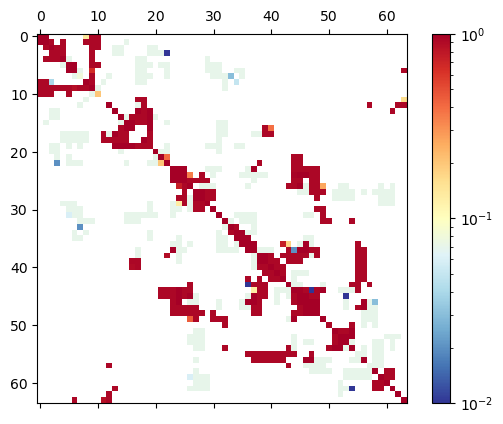

In [12]:
n = 0
n_maps = 100
cond_scale = 6.
rescaled_phi = 0.7
emb = embeddings.iloc[n].values[0]
sample,hic_map = get_HiC(diffusion,emb,n_maps,cond_scale,rescaled_phi)

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

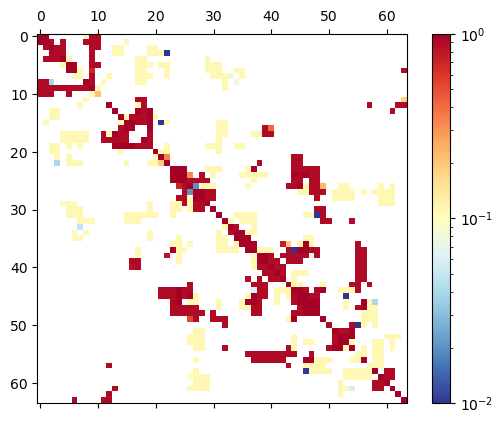

In [13]:
n = 0
n_maps = 100
cond_scale = 6.
rescaled_phi = 0.7
emb = embeddings.iloc[n].values[0]
sample,hic_map = get_HiC(diffusion,emb,n_maps,cond_scale,rescaled_phi)

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

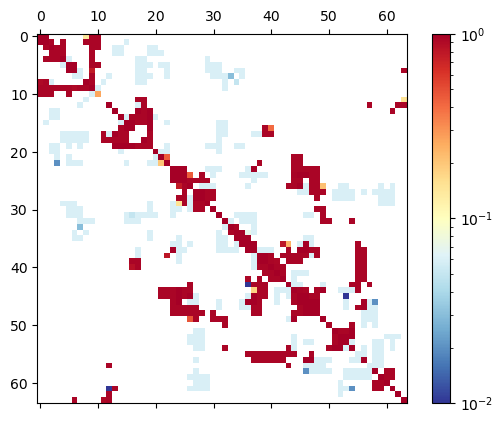

In [14]:
n = 0
n_maps = 100
cond_scale = 3.
rescaled_phi = 0.5
emb = embeddings.iloc[n].values[0]
sample,hic_map = get_HiC(diffusion,emb,n_maps,cond_scale,rescaled_phi)

In [15]:
embeddings.iloc[n].name

(1300000, '22', 16980000)

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

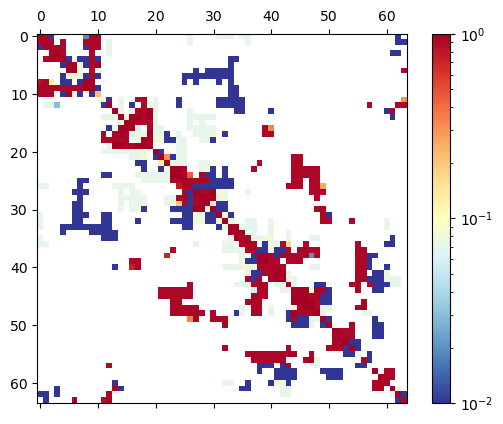

In [16]:
n = 1000
n_maps = 100
cond_scale = 6.
rescaled_phi = 0.7
emb = embeddings.iloc[n].values[0]
sample,hic_map = get_HiC(diffusion,emb,n_maps,cond_scale,rescaled_phi)

In [26]:
import sys
sys.path.insert(1,'../data_utils_v2/')
from Sample import Sample

In [27]:
sample = Sample(data=sample.batch) 

(<Figure size 640x480 with 2 Axes>,
 <Axes: >,
 <matplotlib.colorbar.Colorbar at 0x7fe8dc416620>)

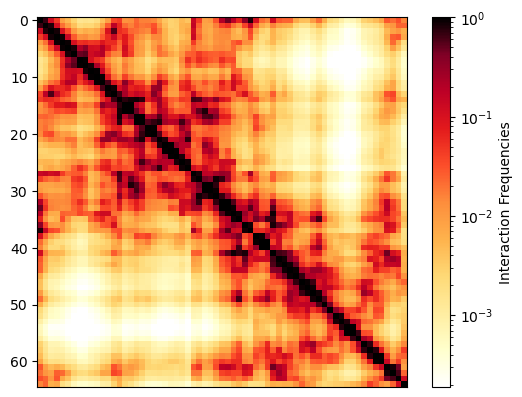

In [67]:
r_c = 1.5
sigma = 4
plot_hic(sample.contact_probabilities(r_c=r_c,sigma=sigma))

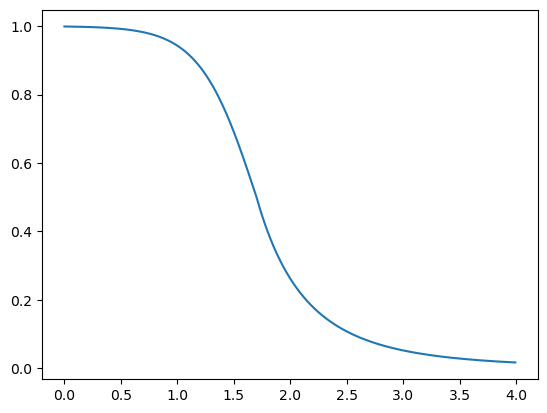

In [63]:
r = torch.arange(0,4,.01)
p = r.clone()

mask = r < r_c 
p[mask] = .5*( 1 + torch.tanh( sigma*( r_c - r[mask] ) ) )

mask^= True 
p[mask] = .5 * ( r_c / r[mask] )**4

plt.plot(r,p)

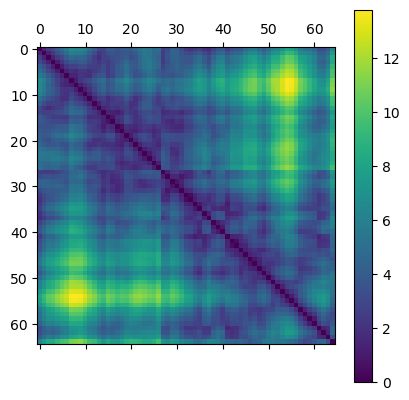

In [31]:
dmap = torch.cdist(sample.coords,sample.coords)
plt.matshow(dmap.mean(0).cpu().numpy())
plt.colorbar()

(<Figure size 640x480 with 2 Axes>,
 <Axes: >,
 <matplotlib.colorbar.Colorbar at 0x7fe8dc0e3ca0>)

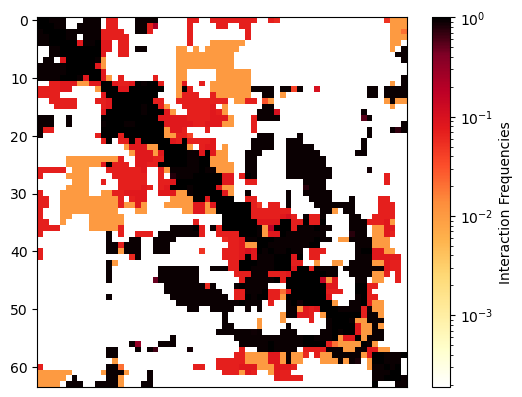

In [71]:
r_c = 1.5
sigma = 4
plot_hic(sample.contact_probabilities(approach='',threshold=3))

(array([  0.,   0.,   2.,   8.,   9.,  13.,  11.,  36.,  17.,  12.,  18.,
        118., 128., 124., 203., 125., 121., 154., 320., 232., 153., 160.,
        136., 196., 176., 198., 185., 292., 264., 333., 267., 302., 270.,
        312., 269., 229., 287., 199., 268., 258., 268., 315., 314., 251.,
        258., 256., 195., 243., 219., 294., 200., 222., 184., 186., 251.,
        193., 258., 189., 211., 194., 198., 202., 158., 181., 153., 188.,
        144., 150., 202., 171., 135., 126., 187.,  78., 164., 123., 123.,
         94., 150., 133., 100.,  89.,  84.,  49., 115.,  88., 108.,  98.,
         94.,  57.,  31.,  82.,  70.,  81.,  88.,  72.,  61.,  38.,  53.,
         67.,  32.,  90.,  32.,  40.,  65.,  68.,  23.,  14.,  39.,  47.,
         44.,  46.,  34.,  27.,  22.,  24.,  13.,  16.,   4.,  36.,  16.,
          7.,  10.,  18.,  14.,  18.,  13.,  11.,   6.,   4.,   4.,   7.,
         16.,  12.,   0.,   7.,  13.,   2.,   7.,   6.,   0.,   1.,  13.,
          7.,   7.,   7.,   7.,   0., 

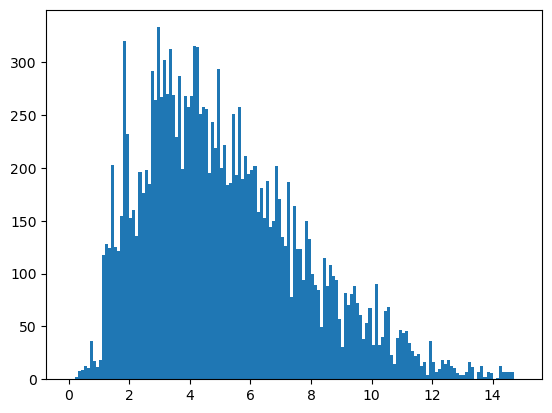

In [33]:
i,j = torch.triu_indices(65,65,1)
plt.hist(dmap[:,i,j].flatten().cpu().numpy(),bins=np.arange(0,15,.1))

In [17]:
embeddings.iloc[n].name

(1300000, '22', 36980000)

In [18]:
#n = 0
n_maps = 100
cond_scale = 6.
rescaled_phi = 0.7
#emb = embeddings.iloc[n].values[0]
emb = embeddings.loc[(1300000, 'X', 23600000),'Data']
sample,hic_map = get_HiC(diffusion,emb,n_maps,cond_scale,rescaled_phi)

KeyError: (1300000, 'X', 23600000)

#### DDIM sampling

In [42]:
fp = './results_large/model-81.pt'

sampling_timesteps = 100 

c,image_size = 1+int(two_channels), num_beads-1
model = Unet(
    dim=128,
    #num_classes,
    cond_drop_prob = 0.5,
    init_dim = None,
    out_dim = None,
    dim_mults=(1, 2, 4, 8),
    channels = c,
    resnet_block_groups = 8,
    learned_variance = False,
    learned_sinusoidal_cond = False,
    random_fourier_features = False,
    learned_sinusoidal_dim = 16,
    attn_dim_head = 32,
    attn_heads = 4,
    embedding_dimensions=embedding_dimensions
)

diffusion = GaussianDiffusion(
    model,
    image_size=image_size,
    timesteps = 1000,
    sampling_timesteps = sampling_timesteps,
    objective = 'pred_noise',
    beta_schedule = 'cosine',
    ddim_sampling_eta = 1.,
    offset_noise_strength = 0.,
    min_snr_loss_weight = False,
    min_snr_gamma = 5
)

try: 
    diffusion.to('cuda')
except:
    pass

diffusion.load(fp)

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

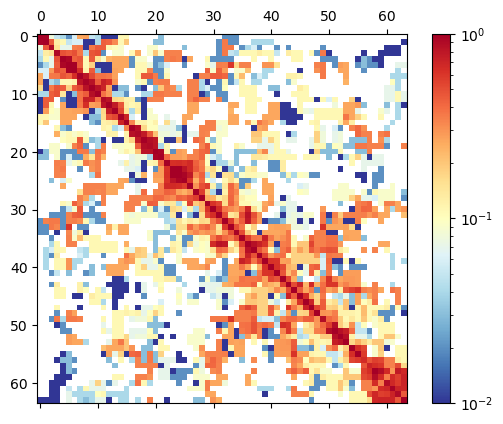

In [43]:
n = 0
n_maps = 100
cond_scale = 6.
rescaled_phi = 0.7
emb = embeddings.iloc[n].values[0]
sample,hic_map = get_HiC(diffusion,emb,n_maps,cond_scale,rescaled_phi)